## Contributors: 
Neal Friesenhahn

### Importing Libraries:

In [1]:
# Import necessary libraries
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Image
from time import sleep
import os
import math
import numpy as np
from sklearn.metrics import classification_report

from amb_sdk.sdk import DarwinSdk

### Configure Darwin:

In [2]:
# Login
ds = DarwinSdk()
file = open("login.txt", "r")
username = file.readline(0)
password = file.readline(1)
ds.set_url('https://amb-demo-api.sparkcognition.com/v1/')
status, msg = ds.auth_login_user('username', 'password')
if not status:
    print(msg)
    

#### Data Path
Make sure to set this to your local machine's path to the data.

In [3]:
path = './'

### Importing Data:
Data used in this project:
https://data.austintexas.gov/Building-and-Development/Issued-Construction-Permits/3syk-w9eu

In [4]:
dataFile = "./Issued_Construction_Permits.csv"
trainName= "train.csv"
testName = 'test.csv'
cleanName= "cleaned.csv"
data = pd.read_csv(dataFile, skipinitialspace=True)

#Columns with detected mixed types
mixedData_col = [52,54,56,58,59,60,61,62,63,64,65,66]

columnsNames = data.columns.values
#excess labels included in feature drop
#Darwin doesn't like mulitple date fields either so they must be dropped as well
#Can't one-hot encode descriptions and Darwin can't process them either, thus they are dropped as well, including Addresses
featureDrop = ['Permit Type Desc', 'Permit Num', 'Permit Class', 'Contractor Trade', 'Applied Date', 
               'Issued Date', 'Status Date', 'Expires Date', 'Completed Date', 'Plumbing Valuation', 'Plumbing Valuation Remodel',
               'Electrical Valuation', 'Electrical Valuation Remodel', 'Mechanical Valuation', 'Mechanical Valuation Remodel',
               'MedGas Valuation', 'MedGas Valuation Remodel', 'Project ID', 'Issuance Method', 'Issued In Last 30 Days',
               'Property Legal Description', 'Description']
#add mixed datatype col to feature drop until later date of processing 
print("Removed mixed data columns from dataset:")
for col in mixedData_col:
    print(columnsNames[col])
    featureDrop.append(columnsNames[col])

#reduce dimensionality and remove excess labels
fullData = data.drop(featureDrop, axis=1)

#pick sample sizes (max is half the dataset due to Darwin restrictions on Big Data)
trainSize = math.floor(len(fullData)/2)
testSize = math.floor(len(fullData)/10)

#sample train and test sets, note currently using .sample() performs without replacement on each instance, meaning
#there might exist overlap between the two sets
testSet = fullData.sample(n=testSize)
trainData = fullData.sample(n=trainSize)

#write out datasets to disk to upload later
testSet.to_csv(os.path.join(path, testName))
trainData.to_csv(os.path.join(path, trainName))

#show data / completed write to disk
trainData.head()

C:\Users\Neal\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (52,54,56,58,59,60,61,62,63,64,65,66) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Removed mixed data columns from dataset:
Contractor Company Name
Contractor Phone
Contractor Address 2
Contractor Zip
Applicant Full Name
Applicant Organization
Applicant Phone
Applicant Address 1
Applicant Address 2
Applicant City
Applicant Zip
Certificate Of Occupancy


,Permit Type,Permit Class Mapped,Work Class,Condominium,Project Name,TCAD ID,Day Issued,Calendar Year Issued,Fiscal Year Issued,Status Current,...,Jurisdiction,Link,Master Permit Num,Latitude,Longitude,Location,Contractor Full Name,Contractor Address 1,Contractor City,Total Lot SQFT
1740669,BP,Residential,New,No,6104 Open Range Trail A 00000,0412360330,MONDAY,1990,1990,Final,...,AUSTIN FULL PURPOSE,https://abc.austintexas.gov/web/permit/public-...,NaN,30.221643,-97.869257,"(30.22164259, -97.86925741)",NaN,NaN,NaN,NaN
13454,MP,Residential,New,No,11024 TORNASOL LN,0420530614,WEDNESDAY,2009,2009,Final,...,AUSTIN FULL PURPOSE,https://abc.austintexas.gov/web/permit/public-...,10313504.0,30.199526,-97.915639,"(30.1995264, -97.91563925)",Twin Burnham,414 THOMPSON LN,Austin,NaN
546727,BP,Residential,New,No,6704 BRANRUST DR,0328060104,FRIDAY,2018,2018,Final,...,AUSTIN FULL PURPOSE,https://abc.austintexas.gov/web/permit/public-...,11862478.0,30.173209,-97.730326,"(30.17320851, -97.7303264)",NaN,NaN,AUSTIN,6470.0
1174552,PP,Residential,New,No,14621 Staked Plains Loop,NaN,MONDAY,2003,2003,Final,...,AUSTIN FULL PURPOSE,https://abc.austintexas.gov/web/permit/public-...,703178.0,30.497760,-97.790828,"(30.49775989, -97.79082807)",NaN,ATTN:LINDA MAYNARD,Austin,NaN
1853033,BP,Commercial,Remodel,No,3100 S Congress Ave Bldg 2e,0407030306,THURSDAY,2004,2005,Final,...,AUSTIN FULL PURPOSE,https://abc.austintexas.gov/web/permit/public-...,245899.0,30.231804,-97.759325,"(30.23180448, -97.75932452)",NaN,916 WEST 12TH STREET,Austin,NaN


In this dataset we will attempt to use the Permit Type as the class label for the data and because of that we need to remove some columns that also act as labels in that capacity that might skew the results. Columns that are similar to Permit type are:

    Permit Type Description (too hard to process due to variablility of descriptions, but also typically contains label name)
    Permit Num (since it contain the type in the code)
    Permit Class (functions much like a label)
    Contractor Trade (plummers typically take plumbing jobs, electricians take electrician jobs thus could act as a label)
    Project ID (applies to series of permits stored in folder in database, unsurprisingly permits are put in similar folders)

Tangental Job indicators: (subject to testing and feature engineering)

    *Plumbing Valuation
    *Plumbing Valuation Remodel
    *Electrical Valuation
    *Electrical Valuation Remodel
    *Mechanical Valuation
    *Mechanical Valuation Remodel 
    *MedGas Valuation
    *MedGas Valuation Remodel

Interesting sidenote our data qualifies as big data under Darwin's algorithms (>500MB in size) as such not only can we sample
at most half our dataset but also the need to remove addional columns before uploading including those above.


### Upload to Darwin

In [5]:
status, dataset = ds.upload_dataset(os.path.join(path, trainName))
if not status:
    print(dataset)

#### Clean dataset

In [6]:
target = "Permit Type"
index = "Applied Date"
model = target + "_model"
status, job_id = ds.clean_data(trainName, target = target)
print(job_id)
if status:
    ds.wait_for_job(job_id['job_name'])
else:
    print(job_id)

{'job_name': 'e84fad6f79b14b5ca3ec17043227d3b0', 'artifact_name': '5015958028fd44f99b769d9aae8b92c9'}
{'status': 'Requested', 'starttime': '2019-04-22T15:51:56.750608', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['train3.csv'], 'artifact_names': ['5015958028fd44f99b769d9aae8b92c9'], 'model_name': None, 'job_error': None}
{'status': 'Requested', 'starttime': '2019-04-22T15:51:56.750608', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['train3.csv'], 'artifact_names': ['5015958028fd44f99b769d9aae8b92c9'], 'model_name': None, 'job_error': None}
{'status': 'Requested', 'starttime': '2019-04-22T15:51:56.750608', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['train3.csv'], 'artifact_names': ['5015958028fd44f99b769d9aae8b92c9'], 'model_name': None, 'job_error': None}
{

{'status': 'Running', 'starttime': '2019-04-22T15:51:56.750608', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['train3.csv'], 'artifact_names': ['5015958028fd44f99b769d9aae8b92c9'], 'model_name': None, 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-22T15:51:56.750608', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['train3.csv'], 'artifact_names': ['5015958028fd44f99b769d9aae8b92c9'], 'model_name': None, 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-22T15:51:56.750608', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['train3.csv'], 'artifact_names': ['5015958028fd44f99b769d9aae8b92c9'], 'model_name': None, 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-22T15:51:56.750608', 'endtime': None, 'percent_complete': 0, 'job_type'

#### Download Cleaned Data

In [9]:
if status:
    ds.wait_for_job(job_id['job_name'])
else:
    print(job_id)
    
status, clean = ds.download_artifact(job_id['artifact_name'])
clean.to_csv(os.path.join(path, cleanName))

{'status': 'Requested', 'starttime': '2019-04-22T16:04:06.632983', 'endtime': None, 'percent_complete': 0, 'job_type': 'TrainModel', 'loss': None, 'generations': 0, 'dataset_names': ['train3.csv'], 'artifact_names': None, 'model_name': 'Permit Type_model3', 'job_error': None}
{'status': 'Requested', 'starttime': '2019-04-22T16:04:06.632983', 'endtime': None, 'percent_complete': 0, 'job_type': 'TrainModel', 'loss': None, 'generations': 0, 'dataset_names': ['train3.csv'], 'artifact_names': None, 'model_name': 'Permit Type_model3', 'job_error': None}
{'status': 'Requested', 'starttime': '2019-04-22T16:04:06.632983', 'endtime': None, 'percent_complete': 0, 'job_type': 'TrainModel', 'loss': None, 'generations': 0, 'dataset_names': ['train3.csv'], 'artifact_names': None, 'model_name': 'Permit Type_model3', 'job_error': None}
{'status': 'Requested', 'starttime': '2019-04-22T16:04:06.632983', 'endtime': None, 'percent_complete': 0, 'job_type': 'TrainModel', 'loss': None, 'generations': 0, 'dat

{'status': 'Running', 'starttime': '2019-04-22T16:04:06.632983', 'endtime': None, 'percent_complete': 0, 'job_type': 'TrainModel', 'loss': None, 'generations': 0, 'dataset_names': ['train3.csv'], 'artifact_names': None, 'model_name': 'Permit Type_model3', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-22T16:04:06.632983', 'endtime': None, 'percent_complete': 0, 'job_type': 'TrainModel', 'loss': None, 'generations': 0, 'dataset_names': ['train3.csv'], 'artifact_names': None, 'model_name': 'Permit Type_model3', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-22T16:04:06.632983', 'endtime': None, 'percent_complete': 0, 'job_type': 'TrainModel', 'loss': None, 'generations': 0, 'dataset_names': ['train3.csv'], 'artifact_names': None, 'model_name': 'Permit Type_model3', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-22T16:04:06.632983', 'endtime': None, 'percent_complete': 0, 'job_type': 'TrainModel', 'loss': None, 'generations': 0, 'dataset_names': [

KeyError: 'artifact_name'

### Create and Train Model

In [8]:
status, job_id = ds.create_model(dataset_names = trainName, \
                                 model_name =  model, \
                                 max_train_time = '00:15')
if status:
    ds.wait_for_job(job_id['job_name'])
else:
    print(job_id)

{'status': 'Requested', 'starttime': '2019-04-22T16:04:06.632983', 'endtime': None, 'percent_complete': 0, 'job_type': 'TrainModel', 'loss': None, 'generations': 0, 'dataset_names': ['train3.csv'], 'artifact_names': None, 'model_name': 'Permit Type_model3', 'job_error': None}
{'status': 'Requested', 'starttime': '2019-04-22T16:04:06.632983', 'endtime': None, 'percent_complete': 0, 'job_type': 'TrainModel', 'loss': None, 'generations': 0, 'dataset_names': ['train3.csv'], 'artifact_names': None, 'model_name': 'Permit Type_model3', 'job_error': None}
{'status': 'Requested', 'starttime': '2019-04-22T16:04:06.632983', 'endtime': None, 'percent_complete': 0, 'job_type': 'TrainModel', 'loss': None, 'generations': 0, 'dataset_names': ['train3.csv'], 'artifact_names': None, 'model_name': 'Permit Type_model3', 'job_error': None}
{'status': 'Requested', 'starttime': '2019-04-22T16:04:06.632983', 'endtime': None, 'percent_complete': 0, 'job_type': 'TrainModel', 'loss': None, 'generations': 0, 'dat

KeyboardInterrupt: 

#### Check status of job

In [12]:
if status:
    ds.wait_for_job(job_id['job_name'])
else:
    print(job_id)

{'status': 'Complete', 'starttime': '2019-04-22T16:04:06.632983', 'endtime': '2019-04-22T16:55:51.067499', 'percent_complete': 100, 'job_type': 'TrainModel', 'loss': 1.1808252334594727, 'generations': 0, 'dataset_names': ['train3.csv'], 'artifact_names': None, 'model_name': 'Permit Type_model3', 'job_error': ''}


### Analyze Model

In [13]:
# Retrieve feature importance of built model
status, artifact = ds.analyze_model(model)
sleep(1)
if status:
    ds.wait_for_job(artifact['job_name'])
else:
    print(artifact)
status, feature_importance = ds.download_artifact(artifact['artifact_name'])


{'status': 'Requested', 'starttime': '2019-04-22T17:06:19.820451', 'endtime': None, 'percent_complete': 0, 'job_type': 'AnalyzeModel', 'loss': 1.1808252334594727, 'generations': 0, 'dataset_names': None, 'artifact_names': ['41932f3e7fdd4fbdac6ec6cfe9ee0dae'], 'model_name': 'Permit Type_model3', 'job_error': None}
{'status': 'Requested', 'starttime': '2019-04-22T17:06:19.820451', 'endtime': None, 'percent_complete': 0, 'job_type': 'AnalyzeModel', 'loss': 1.1808252334594727, 'generations': 0, 'dataset_names': None, 'artifact_names': ['41932f3e7fdd4fbdac6ec6cfe9ee0dae'], 'model_name': 'Permit Type_model3', 'job_error': None}
{'status': 'Requested', 'starttime': '2019-04-22T17:06:19.820451', 'endtime': None, 'percent_complete': 0, 'job_type': 'AnalyzeModel', 'loss': 1.1808252334594727, 'generations': 0, 'dataset_names': None, 'artifact_names': ['41932f3e7fdd4fbdac6ec6cfe9ee0dae'], 'model_name': 'Permit Type_model3', 'job_error': None}
{'status': 'Requested', 'starttime': '2019-04-22T17:06:

{'status': 'Requested', 'starttime': '2019-04-22T17:06:19.820451', 'endtime': None, 'percent_complete': 0, 'job_type': 'AnalyzeModel', 'loss': 1.1808252334594727, 'generations': 0, 'dataset_names': None, 'artifact_names': ['41932f3e7fdd4fbdac6ec6cfe9ee0dae'], 'model_name': 'Permit Type_model3', 'job_error': None}
{'status': 'Requested', 'starttime': '2019-04-22T17:06:19.820451', 'endtime': None, 'percent_complete': 0, 'job_type': 'AnalyzeModel', 'loss': 1.1808252334594727, 'generations': 0, 'dataset_names': None, 'artifact_names': ['41932f3e7fdd4fbdac6ec6cfe9ee0dae'], 'model_name': 'Permit Type_model3', 'job_error': None}
{'status': 'Requested', 'starttime': '2019-04-22T17:06:19.820451', 'endtime': None, 'percent_complete': 0, 'job_type': 'AnalyzeModel', 'loss': 1.1808252334594727, 'generations': 0, 'dataset_names': None, 'artifact_names': ['41932f3e7fdd4fbdac6ec6cfe9ee0dae'], 'model_name': 'Permit Type_model3', 'job_error': None}
{'status': 'Requested', 'starttime': '2019-04-22T17:06:

#### Check Status of Job

In [14]:
if status:
    ds.wait_for_job(artifact['job_name'])
else:
    print(artifact)
status, feature_importance = ds.download_artifact(artifact['artifact_name'])

{'job_name': '150995e5beb3465c885249d9b45c700c', 'artifact_name': '41932f3e7fdd4fbdac6ec6cfe9ee0dae'}


Display most important features of the model.

In [15]:
feature_importance[:10]

Unnamed: 0                 0.412748
Master Permit Num          0.107765
Total Job Valuation        0.040575
Housing Units              0.036189
Fiscal Year Issued         0.032267
Total Valuation Remodel    0.030981
Calendar Year Issued       0.027508
Longitude                  0.026773
Latitude                   0.026647
Number Of Floors           0.026000
dtype: float64

### Predictions

#### Perform model prediction on the training dataset.

In [16]:
status, artifact = ds.run_model(trainName, model)
sleep(1)
ds.wait_for_job(artifact['job_name'])

{'status': 'Requested', 'starttime': '2019-04-22T17:18:53.113467', 'endtime': None, 'percent_complete': 0, 'job_type': 'RunModel', 'loss': 1.1808252334594727, 'generations': 0, 'dataset_names': ['train3.csv'], 'artifact_names': ['e3c45b8a632646ddb61bd58e22516329'], 'model_name': 'Permit Type_model3', 'job_error': None}
{'status': 'Requested', 'starttime': '2019-04-22T17:18:53.113467', 'endtime': None, 'percent_complete': 0, 'job_type': 'RunModel', 'loss': 1.1808252334594727, 'generations': 0, 'dataset_names': ['train3.csv'], 'artifact_names': ['e3c45b8a632646ddb61bd58e22516329'], 'model_name': 'Permit Type_model3', 'job_error': None}
{'status': 'Requested', 'starttime': '2019-04-22T17:18:53.113467', 'endtime': None, 'percent_complete': 0, 'job_type': 'RunModel', 'loss': 1.1808252334594727, 'generations': 0, 'dataset_names': ['train3.csv'], 'artifact_names': ['e3c45b8a632646ddb61bd58e22516329'], 'model_name': 'Permit Type_model3', 'job_error': None}
{'status': 'Requested', 'starttime': 

{'status': 'Requested', 'starttime': '2019-04-22T17:18:53.113467', 'endtime': None, 'percent_complete': 0, 'job_type': 'RunModel', 'loss': 1.1808252334594727, 'generations': 0, 'dataset_names': ['train3.csv'], 'artifact_names': ['e3c45b8a632646ddb61bd58e22516329'], 'model_name': 'Permit Type_model3', 'job_error': None}
{'status': 'Requested', 'starttime': '2019-04-22T17:18:53.113467', 'endtime': None, 'percent_complete': 0, 'job_type': 'RunModel', 'loss': 1.1808252334594727, 'generations': 0, 'dataset_names': ['train3.csv'], 'artifact_names': ['e3c45b8a632646ddb61bd58e22516329'], 'model_name': 'Permit Type_model3', 'job_error': None}
{'status': 'Requested', 'starttime': '2019-04-22T17:18:53.113467', 'endtime': None, 'percent_complete': 0, 'job_type': 'RunModel', 'loss': 1.1808252334594727, 'generations': 0, 'dataset_names': ['train3.csv'], 'artifact_names': ['e3c45b8a632646ddb61bd58e22516329'], 'model_name': 'Permit Type_model3', 'job_error': None}
{'status': 'Requested', 'starttime': 

(False, 'Waited for 10.0 minutes. Re-run wait_for_job to wait longer.')

#### Check status of job

In [17]:
ds.wait_for_job(artifact['job_name'])

{'status': 'Running', 'starttime': '2019-04-22T17:18:53.113467', 'endtime': None, 'percent_complete': 0, 'job_type': 'RunModel', 'loss': 1.1808252334594727, 'generations': 0, 'dataset_names': ['train3.csv'], 'artifact_names': ['e3c45b8a632646ddb61bd58e22516329'], 'model_name': 'Permit Type_model3', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-22T17:18:53.113467', 'endtime': None, 'percent_complete': 0, 'job_type': 'RunModel', 'loss': 1.1808252334594727, 'generations': 0, 'dataset_names': ['train3.csv'], 'artifact_names': ['e3c45b8a632646ddb61bd58e22516329'], 'model_name': 'Permit Type_model3', 'job_error': ''}
{'status': 'Complete', 'starttime': '2019-04-22T17:18:53.113467', 'endtime': '2019-04-22T17:29:39.196006', 'percent_complete': 100, 'job_type': 'RunModel', 'loss': 1.1808252334594727, 'generations': 0, 'dataset_names': ['train3.csv'], 'artifact_names': ['e3c45b8a632646ddb61bd58e22516329'], 'model_name': 'Permit Type_model3', 'job_error': ''}


(True, 'Job completed')

#### Download predictions from Darwin.

In [18]:
status, prediction = ds.download_artifact(artifact['artifact_name'])
prediction.head()

,Permit Type,prob_BP,prob_DS,prob_EP,prob_MP,prob_PP
0,BP,9.999932e-01,8.870000e-08,0.000005,4.229000e-07,0.000002
1,MP,1.777381e-04,2.984204e-04,0.260692,6.096291e-01,0.129202
2,BP,9.998208e-01,5.730000e-08,0.000053,7.275790e-05,0.000053
3,PP,2.865000e-07,2.526000e-07,0.000012,5.443000e-06,0.999982
4,BP,9.998945e-01,1.236810e-05,0.000065,2.202010e-05,0.000006


#### (optional) Write to disk downloaded predictions

In [ ]:
prediction.to_csv(os.path.join(path, "predictions.csv"))

#### Create visualizations for comparing predictions with actual target. 

             precision    recall  f1-score   support

         BP       1.00      1.00      1.00    210356
         DS       1.00      1.00      1.00     50696
         EP       0.89      0.91      0.90    272735
         MP       0.90      0.90      0.90    207485
         PP       0.88      0.85      0.86    207995

avg / total       0.92      0.92      0.92    949267



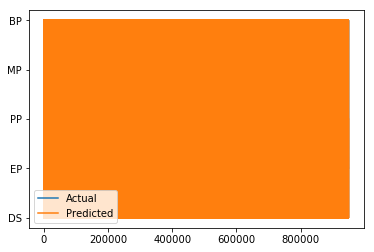

In [19]:

unq = prediction[target].unique()[::-1]
p = np.zeros((len(prediction),))
a = np.zeros((len(prediction),))
for i,q in enumerate(unq):
    p += i*(prediction[target] == q).values
    a += i*(trainData[target] == q).values
#Plot predictions vs actual
plt.plot(a)
plt.plot(p)
plt.legend(['Actual','Predicted'])
plt.yticks([i for i in range(len(unq))],[q for q in unq]);
print(classification_report(trainData[target], prediction[target]))

#### Sorted Predictions versus Sorted Actual

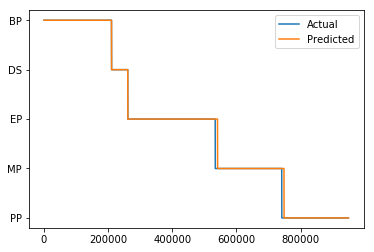

In [21]:
prediction[target].astype('category')
prediction.sort_values(by = target, inplace=True)
trainData[target].astype('category')
trainData.sort_values(by = target, inplace = True)

unq = prediction[target].unique()[::-1]
p = np.zeros((len(prediction),))
a = np.zeros((len(prediction),))
for i,q in enumerate(unq):
    p += i*(prediction[target] == q).values
    a += i*(trainData[target] == q).values
#Plot predictions vs actual
plt.plot(a)
plt.plot(p)
plt.legend(['Actual','Predicted'])
plt.yticks([i for i in range(len(unq))],[q for q in unq]);

#### Perform model prediction on test dataset from holdout method.
Upload test data.

In [22]:
status, dataset = ds.upload_dataset(os.path.join(path, testName))
if not status:
    print(dataset)

Clean test data. 

In [23]:
status, job_id = ds.clean_data(testName, model_name = model)
print("Model:\n",model)
print("Target: \n",target)
print(job_id)
if status:
    ds.wait_for_job(job_id['job_name'])
else:
    print(job_id)

Model:
 Permit Type_model3
Target: 
 Permit Type
{'job_name': 'a66837723c8743f7888f8d29cce24d53', 'artifact_name': 'c81882dd77a24ce7b69853f9f43cf700'}
{'status': 'Requested', 'starttime': '2019-04-22T17:34:25.069529', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['test3.csv'], 'artifact_names': ['c81882dd77a24ce7b69853f9f43cf700'], 'model_name': None, 'job_error': None}
{'status': 'Requested', 'starttime': '2019-04-22T17:34:25.069529', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['test3.csv'], 'artifact_names': ['c81882dd77a24ce7b69853f9f43cf700'], 'model_name': None, 'job_error': None}
{'status': 'Requested', 'starttime': '2019-04-22T17:34:25.069529', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['test3.csv'], 'artifact_names': ['c81882dd77a24ce7b69853f9f43cf7

{'status': 'Requested', 'starttime': '2019-04-22T17:34:25.069529', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['test3.csv'], 'artifact_names': ['c81882dd77a24ce7b69853f9f43cf700'], 'model_name': None, 'job_error': None}
{'status': 'Requested', 'starttime': '2019-04-22T17:34:25.069529', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['test3.csv'], 'artifact_names': ['c81882dd77a24ce7b69853f9f43cf700'], 'model_name': None, 'job_error': None}
{'status': 'Requested', 'starttime': '2019-04-22T17:34:25.069529', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['test3.csv'], 'artifact_names': ['c81882dd77a24ce7b69853f9f43cf700'], 'model_name': None, 'job_error': None}
{'status': 'Requested', 'starttime': '2019-04-22T17:34:25.069529', 'endtime': None, 'percent_complete': 0,

Run model on test dataset. 

In [ ]:
status, artifact = ds.run_model(testName, model)
sleep(1)
ds.wait_for_job(artifact['job_name'])

#### Create visualizations for comparing predictions with actual target.

In [ ]:
status, prediction = ds.download_artifact(artifact['artifact_name'])
df = pd.read_csv(os.path.join(path,testName))
unq = prediction[target].unique()[::-1]
p = np.zeros((len(prediction),))
a = np.zeros((len(prediction),))
for i,q in enumerate(unq):
    p += i*(prediction[target] == q).values
    a += i*(df[target] == q).values
#Plot predictions vs actual
plt.plot(a)
plt.plot(p)
plt.legend(['Actual','Predicted'])
plt.yticks([i for i in range(len(unq))],[q for q in unq]);
print(classification_report(df[target], prediction[target]))

### Darwin' Pick for machine learning model

In [ ]:
status, model_type = ds.lookup_model_name(model)
print(model_type['description']['best_genome'])

## Clean up

In [ ]:
ds.delete_all_datasets()
ds.delete_all_models()
ds.delete_all_artifacts()